<a href="https://colab.research.google.com/github/djsabelo/BiosignalsDeepLearningWorkshop/blob/main/SignalProcessingForSynthesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Processing:

1. Sacar ficheiro - meter em numpy arrays
2. Fazer plot aos dados com dois ou mais sinais
3. Cortar os dados - Precisamos de fazer isto tendo em conta que vamos fazer a segmentação ???
4. Remover a média e normalizar com o maximo absoluto
5. Subamostragem (decimate)
5. Fazer plot aos dados com dois ou mais sinais
6. Remover ruido - smooth
7. Fazer plot aos dados
8. Mostrar e tratar do baseline wander
9. Remover o minimo
10. Quantização
11. Fazer plot aos dados
12. Segmentação - tens que garantir pelo menos 2 ciclos - sliding window (janelas 2^x + 1)
11. Fazer plot de muitas janelas





# Signal Processing for  Synthesis

The application of Deep Learning for biosignals synthesis depends on the quality of signal processing and even on the quality of the raw signal.

In this workshop, we will go through the signal processing steps that are usually applied for biosignals synthesis using Python. Here, we will use **numpy** to ease mathematical operations, **matplotlib** to visualize the results of each step, **scipy** for specific processing operations and **os** to search data files.

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.io import loadmat
from scipy.signal import decimate

## Reading Data

The first step for the application of signal processing is to read the files that contain the data. In this case, we will use ECG files from the Fantasia dataset, that were previously downloaded and, so, can be reached using **os**.

In [14]:
# Find files in folder
folder = './BiosignalsDeepLearningWorkshop/data/'
files = os.listdir(folder)

print(files)

['f1o05m.mat', 'f1o04m.mat', 'info', 'f1o03m.mat', 'f1o02m.mat', 'f1o01m.mat']


Having the list of files we can now read the data contained in them and store them in a list.

However, given that *.mat* files are read as dictionaries, we will simply store the values that correspond to the actual ECG signals. In this case, the key that identifies the signals is *'val'*, thus we index get the values contained in that key.

Moreover, each file contains a respiration signal and an ECG signal, but we will keep only the ECG of each file.

In [36]:
# Iterate over data files and store the data in a list
data = []
for file in files:
  if '.mat' in file: # check if file corresponds to a data file
    folder_file = os.path.join(folder, file) # join the folder path and file name
    signals = loadmat(folder_file)['val'] # Get the signals from file
    single_signal = signals[1] # Get the first signal
    data.append(single_signal) # Load and store the data

Let's check if the data is in the format we expected. In this case, since the sampling frequency is 250 Hz, we will build a time axis using the function **linspace** from **numpy** Python package.

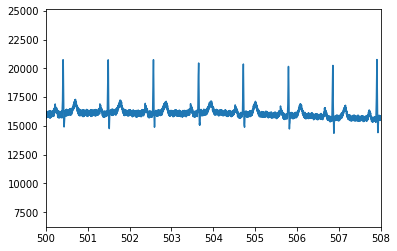

In [43]:
# Get the first signal to plot
signal = data[0]

# Produce the time axis
time = np.arange(0, len(signal)/250, 1/250)

# Make a figure
plt.figure()
# Plot the signal in the figure
plt.plot(time, signal)
# Let's see only part of the signal
plt.xlim(500, 508)
# Show plot
plt.show()

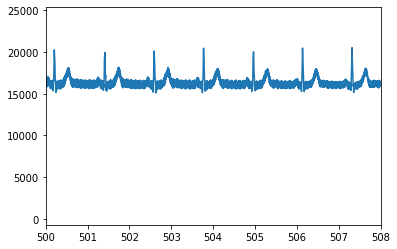

In [44]:
# Let's see the second signal
signal = data[1]
time = np.arange(0, len(signal)/250, 1/250)

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

## Normalise Data

The first step of signal processing is to normalise the signals. 

In this case, we will remove the mean and divide by the maximum of the absolute of the signal so that the resulting values of the signals will be between -0.5 and 0.5.

Since we have various signals, we will interate over the list that contains them and will store them in a list.

In [45]:
# Start the new list
normalised_data = []
# Iterate over all signals
for signal in data:
  mean_value = np.mean(signal) # Calculate the mean of the signal
  abs_signal = np.abs(signal) # Calculate the absolute of the signal
  max_abs_signal = np.max(abs_signal) # Get the maximum value of the absolute signal
  normalised_signal = (signal - mean_value) / max_abs_signal
  normalised_data.append(normalised_signal)

Let's plot the same portions of the same signals. Note that the values of the y-axis changed.

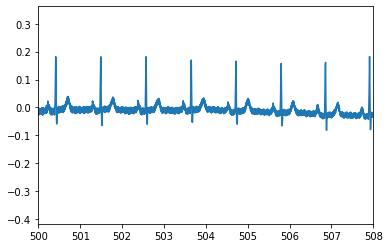

In [47]:
# Let's see the first normalised signal
signal = normalised_data[0]
time = np.arange(0, len(signal)/250, 1/250)

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

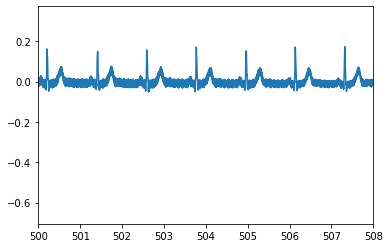

In [48]:
# Let's see the second normalised signal
signal = normalised_data[1]
time = np.arange(0, len(signal)/250, 1/250)

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

## Subsampling

Given that Deep Learning models are "slow" during training, due to the number of iterations and complexity of operations that are required, we will subsample our data, which will save us some time when training our model.

To do this, we will use _decimate_, which is a function from **scipy** which handles this operation maintaing the integrity of the data.

In [53]:
# Build the list to store the subsampled data
subsampled_data = []

# Iterate over the normalised data and subsample
for signal in normalised_data:
  subsampled_signal = decimate(signal, 5) # Subsample by a factor of 5
  subsampled_data.append(subsampled_signal)

1000000 200000
1000000 200000
1000000 200000
1000000 200000
1000000 200000


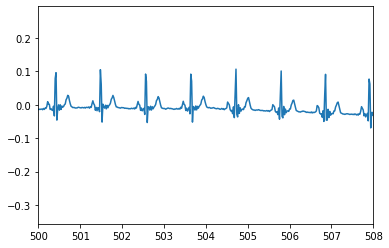

In [56]:
# Let's see the first subsampled signal
signal = subsampled_data[0]
time = np.arange(0, len(signal)/(250/5), 1/(250/5))

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

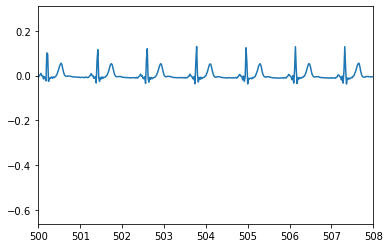

In [57]:
# Let's see the second subsampled signal
signal = subsampled_data[1]
time = np.arange(0, len(signal)/(250/5), 1/(250/5))

plt.figure()
plt.plot(time, signal)
plt.xlim(500, 508)
plt.show()

In [ ]:
import scipy.interpolate as itp

def interpolate_signal(time, new_time, signal):
    """
    This function uses the linear interpolates of the input signal with a certain number of samples with "time" 
    timestamp vector, according to the "new_time" vector.
     
    :param time: vector containing the the timestamps for the signal input 
    :param new_time: vector containing the new timestamps for interpolation
    :param signal: vector with the values associated with each timestamp of the "time" vector
    :return: 
        The interpolated version of the input signal for the "new_time" vector timestamps 
    """

    f = itp.interp1d(time, signal, fill_value="extrapolate")
    return f(new_time)


def process_hr(data, quantization_size=1000):
    """
        The function makes a preprocessing for the HR data and also stores the maximum and minimum values of the
        HR across all records in the data dictionary. This preprocessing includes interpolation, minimum subtraction, 
        maximum normalization and quantization. 

        :param data: data dictionary containing all information
        :param quantization_size: number of steps to be used in the quantization process
        :return:
            data: updated version of the dictionary (this may be accessed, since it is a global variable, but for a 
            latter publication of this code, it should be protected) 
            normalized_array: list containing all numpy array processed HR records 
    """
    # For the synchronization of both signals, I chose to interpolate the hr values.
    # Since the hr values are made of a square signal the interpolation will not be far from the original
    interpolated_hr = [interpolate_signal(hr_time, ppg_time, hr)
                       for hr_time, ppg_time, hr in zip(data["hr_times"], data["ppg_times"], data["hr_values"])]

    
    # Check if the interpolation was successfull
    # for i in range(data["size"]):
    #    plt.plot(data["hr_times"][i], normalized_hr[i], "k", alpha=0.7, label="HR")
    #    plt.plot(data["ppg_times"][i], interpolated_hr[i], "b", alpha=0.7, label="HR")
    #    plt.show()

    # In order to maintain the distribution of values across all subjects, I chose to normalize the data according
    # to the minimum and maximum values across the all records

    max = np.max(np.array([np.max(record) for record in interpolated_hr]))
    min = np.min(np.array([np.min(record) for record in interpolated_hr]))
    
    data["hr_max"] = max
    data["hr_min"] = min

    # The minimum is removed and the set is scaled
    normalized_array = [record - min for record in interpolated_hr] # Remove minimum
    normalized_array = [record / max for record in normalized_array] # Normalization step

    # Quantization step
    # this step reduces the dimentionality of the signal, ensuring that the selected model (GRU) learns
    normalized_array = [np.around(record * (quantization_size-1)).astype(int) for record in normalized_array]


    return data, normalized_array

    def process_ppg(records_dictionary, quantization_size=1000):
    times = []
    normalized_array = []
    updated_ppg = []
    for ppg_values, hr_time, ppg_time in \
            zip(records_dictionary["ppg_values"], records_dictionary["hr_times"], records_dictionary["ppg_times"]):
        # Since this data is not synchronized with the hr_data, we will remove the first points which does not have
        # any respective value. Regarding the interpolation of the hr data, this will make the results more reliable.
        first_index = np.where(ppg_time > hr_time[0])[0][0]
        updated_ppg.append(ppg_values[:, first_index:])
        times.append(ppg_time[first_index:])

        normalized_record = ppg_values[:, first_index:]
        normalized_record -= np.expand_dims(np.min(normalized_record, axis=1), -1) \
                             * np.ones((1, np.shape(normalized_record)[-1]))
                             # Remove mean using algebric equation for speed performance
        normalized_record = normalized_record / np.max(abs(normalized_record))  # Normalization step
        #normalized_record = normalized_record / np.std(abs(normalized_record))  # Normalization step
        normalized_array.append(normalized_record)

    return times, normalized_array, updated_ppg